In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:
tSI_data = genfromtxt('tSI_data.csv', delimiter=',') #in the form of [t, S, I]
tao_data = genfromtxt('tao_data.csv', delimiter=',') #in the form of [t, tao_star, T_star, us]


starting training...

ipykernel_launcher:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
ipykernel_launcher:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
epoch:  0
loss:  tensor(141.4241, grad_fn=<DivBackward0>)
epoch:  100
loss:  tensor(863.0142, grad_fn=<DivBackward0>)
epoch:  200
loss:  tensor(20.3806, grad_fn=<DivBackward0>)
epoch:  300
loss:  tensor(4.7929, grad_fn=<DivBackward0>)
epoch:  400
loss:  tensor(10.1277, grad_fn=<DivBackward0>)
epoch:  500
loss:  tensor(19.0481, grad_fn=<DivBackward0>)
epoch:  600
loss:  tensor(10.3554, grad_fn=<DivBackward0>)
epoch:  700
loss:  tensor(51.2007, grad_fn=<DivBackward0>)
epoch:  800
loss:  tensor(126.4485, grad_fn=<DivBackward0>)
epoch:

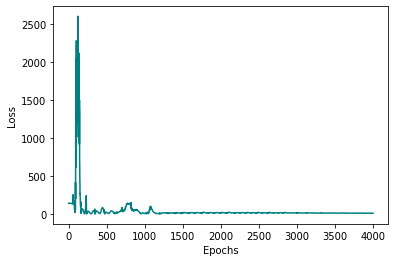

In [3]:
class DINN:
    def __init__(self, t, S_data, I_data, tao_data, T_star_data, u_data): #, t, S_data, I_data, tao_data, T_star_data, u
        self.t = torch.tensor(t).float()
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.taos = torch.tensor(tao_data)
        self.T_stars = torch.tensor(T_star_data)
        self.u = torch.tensor(u_data).float()

        #learnable parameters
        self.alpha1=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alpha2=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta=torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #NN
        self.nx = self.net_x()
        self.params = list(self.nx.parameters())
        self.params.extend(list([self.alpha1, self.alpha2, self.mu, self.beta]))
        
    #nets
    class net_x(nn.Module): # input = [t, u]
        def __init__(self):
            super(DINN.net_x, self).__init__()
            self.fc1=nn.Linear(1, 64) #takes t
            self.fc2=nn.Linear(64, 64)
            self.fc3=nn.Linear(64, 64)
            self.fc4=nn.Linear(64, 64)
            self.fc5=nn.Linear(64, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 64)
            self.fc8=nn.Linear(64, 64)
            self.out=nn.Linear(64, 2) #outputs S, I

            self.fc11=nn.Linear(1, 64) #takes u
            self.fc22=nn.Linear(64, 64)
            self.fc33=nn.Linear(64, 64)
            self.fc44=nn.Linear(64, 64)
            self.fc55=nn.Linear(64, 64)
            self.fc66=nn.Linear(64, 64)
            self.fc77=nn.Linear(64, 64)
            self.fc88=nn.Linear(64, 64)
            self.outout=nn.Linear(64, 2) #outputs tao, T*

        def forward(self, t, u):
            si=F.relu(self.fc1(t))
            si=F.relu(self.fc2(si))
            si=F.relu(self.fc3(si))
            si=F.relu(self.fc4(si))
            si=F.relu(self.fc5(si))
            si=F.relu(self.fc6(si))
            si=F.relu(self.fc7(si))
            si=F.relu(self.fc8(si))
            si=self.out(si)

            taot=F.relu(self.fc11(u))
            taot=F.relu(self.fc22(taot))
            taot=F.relu(self.fc33(taot))
            taot=F.relu(self.fc44(taot))
            taot=F.relu(self.fc55(taot))
            taot=F.relu(self.fc66(taot))
            taot=F.relu(self.fc77(taot))
            taot=F.relu(self.fc88(taot))
            taot=self.outout(taot)
            return si, taot    
    
    
    def net_f(self, t, u):
        si, taot = self.nx(t, u) #input = tensor of size 2 
        S, I = si[:,0], si[:,1]
        tao, T_star = 3*torch.sigmoid(taot[:,0]), 3*torch.sigmoid(taot[:,1]) #maybe change to not 0,3

        S_t = grad(S, t, retain_graph=True)[0][0] #derivative of S_pred wrt t              
        I_t = grad(I, t, retain_graph=True)[0][0] #derivative of I_pred wrt t

        f1 = S_t + self.beta * S * I + u * (t > tao) * self.alpha1
        f2 = I_t - self.beta * S * I + self.mu * I + u * (t > tao) * self.alpha2

        return f1, f2, S, I, tao, T_star
    
        
    def train(self, n_epochs):
        print('\nstarting training...\n')
        losses = []


        learning_rate = 0.0005
        optimizer = optim.Adam(self.params, lr = learning_rate)
        
        for epoch in range(n_epochs):
            S_pred_list= []
            I_pred_list= []
            tao_pred_list= []
            T_star_pred_list = []

            #print('epoch: ', epoch)
            optimizer.zero_grad()
            #print('\nself.alpha1', self.alpha1) 
            for time_step in range(len(self.t)):

                t_value, u_value = self.t[time_step], self.u[time_step]
                t_value = torch.tensor(t_value, requires_grad=True).unsqueeze(0).unsqueeze(1)
                u_value = torch.tensor(u_value, requires_grad=True).unsqueeze(0).unsqueeze(1)
                
                f1, f2, S_pred, I_pred, tao_pred, T_star_pred = self.net_f(t_value, u_value)
                S_pred_list.append(S_pred)
                I_pred_list.append(I_pred)
                tao_pred_list.append(tao_pred)
                T_star_pred_list.append(T_star_pred)

                loss = (torch.mean(torch.square(self.S[time_step]-S_pred))+torch.mean(torch.square(self.I[time_step]-I_pred)) \
                    +torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) \
                    +torch.mean(torch.square(self.taos[time_step]-tao_pred)) + torch.mean(torch.square(self.T_stars[time_step]-T_star_pred)))/100 

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.nx.parameters(), 500) #gradient clipping
            optimizer.step()
            losses.append(loss)
            if epoch % 100 == 0:
                print('epoch: ', epoch)
                print('loss: ' ,loss)
            #print('self.alpha1 after the training!!!: ', self.alpha1)
            
        plt.plot(losses, color = 'teal')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        return S_pred_list, I_pred_list, tao_pred_list, T_star_pred_list

dinn = DINN(tSI_data[0], tSI_data[1], tSI_data[2], tao_data[1], tao_data[2], tao_data[3]) #t, S_data, I_data, tao_data, T_star_data, u
S_pred_list, I_pred_list, tao_pred_list, T_star_pred_list = dinn.train(4000) #train

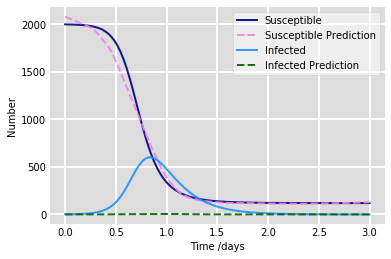

In [4]:
# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tSI_data[0], tSI_data[1], 'navy', alpha=0.9, lw=2, label='Susceptible')
ax.plot(tSI_data[0], S_pred_list, 'violet', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')
ax.plot(tSI_data[0], tSI_data[2], 'dodgerblue', alpha=0.9, lw=2, label='Infected')
ax.plot(tSI_data[0], I_pred_list, 'darkgreen', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

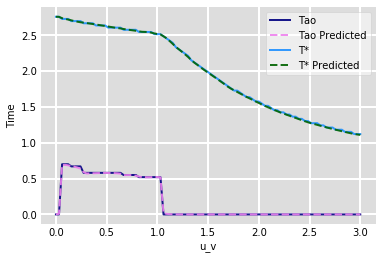

In [5]:
# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tao_data[3], tao_data[1], 'navy', alpha=0.9, lw=2, label='Tao')
ax.plot(tao_data[3], tao_pred_list,'violet', alpha=0.9, lw=2, label='Tao Predicted', linestyle='dashed')
ax.plot(tao_data[3], tao_data[2], 'dodgerblue', alpha=0.9, lw=2, label='T*')
ax.plot(tao_data[3], T_star_pred_list, 'darkgreen', alpha=0.9, lw=2, label='T* Predicted', linestyle='dashed')
ax.set_xlabel('u_v')
ax.set_ylabel('Time')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [6]:
print('alpha1: (goal 1)', dinn.alpha1)
print('\nalpha2: (goal 0)', dinn.alpha2)
print('\nbeta: (goal 0.0075): ', dinn.beta)
print('\nmu (goal 5): ', dinn.mu)


alpha1: (goal 1) Parameter containing:
tensor([2.4464], requires_grad=True)

alpha2: (goal 0) Parameter containing:
tensor([2.5548], requires_grad=True)

beta: (goal 0.0075):  Parameter containing:
tensor([0.4691], requires_grad=True)

mu (goal 5):  Parameter containing:
tensor([2.7998], requires_grad=True)
